# Подбор гиперпараметров модели и кросс-валидация

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_boston
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
iris = load_iris()

# Недообучение и [переобучение](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5) моделей
- [Детальная статья про переобучение](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5) 
- [Раздел про переобучение из scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)
- [Дилемма смещения–дисперсии](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%BB%D0%B5%D0%BC%D0%BC%D0%B0_%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F%E2%80%93%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B8)

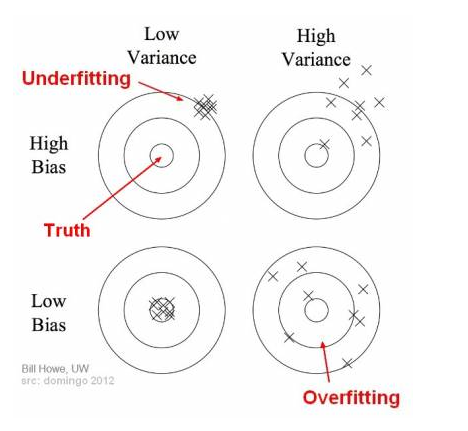

In [3]:
Image('img/bv1.png', width='50%')

In [4]:
# Разделение выборки на обучающую и тестовую
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris.data, iris.target, test_size=0.5, random_state=1)

In [5]:
# В моделях k-ближайших соседей большое значение k 
# ведёт к большому смещению и низкой дисперсии (недообучению)
# 70 ближайших соседей
cl1_1 = KNeighborsClassifier(n_neighbors=70)
cl1_1.fit(iris_X_train, iris_y_train)
target1_0 = cl1_1.predict(iris_X_train)
target1_1 = cl1_1.predict(iris_X_test)
accuracy_score(iris_y_train, target1_0), accuracy_score(iris_y_test, target1_1)

(0.6533333333333333, 0.6266666666666667)

In [6]:
# 5 ближайших соседей
cl1_2 = KNeighborsClassifier(n_neighbors=5)
cl1_2.fit(iris_X_train, iris_y_train)
target1_0 = cl1_2.predict(iris_X_train)
target1_1 = cl1_2.predict(iris_X_test)
accuracy_score(iris_y_train, target1_0), accuracy_score(iris_y_test, target1_1)

(0.9466666666666667, 0.9466666666666667)

In [7]:
# 1 ближайший сосед - "условное" переобучение
cl1_2 = KNeighborsClassifier(n_neighbors=1)
cl1_2.fit(iris_X_train, iris_y_train)
target1_0 = cl1_2.predict(iris_X_train)
target1_1 = cl1_2.predict(iris_X_test)
accuracy_score(iris_y_train, target1_0), accuracy_score(iris_y_test, target1_1)

(1.0, 0.9466666666666667)

# Схема обучения

На прошлом занятии мы познакомились со следующей (упрощенной) схемой обучения модели:

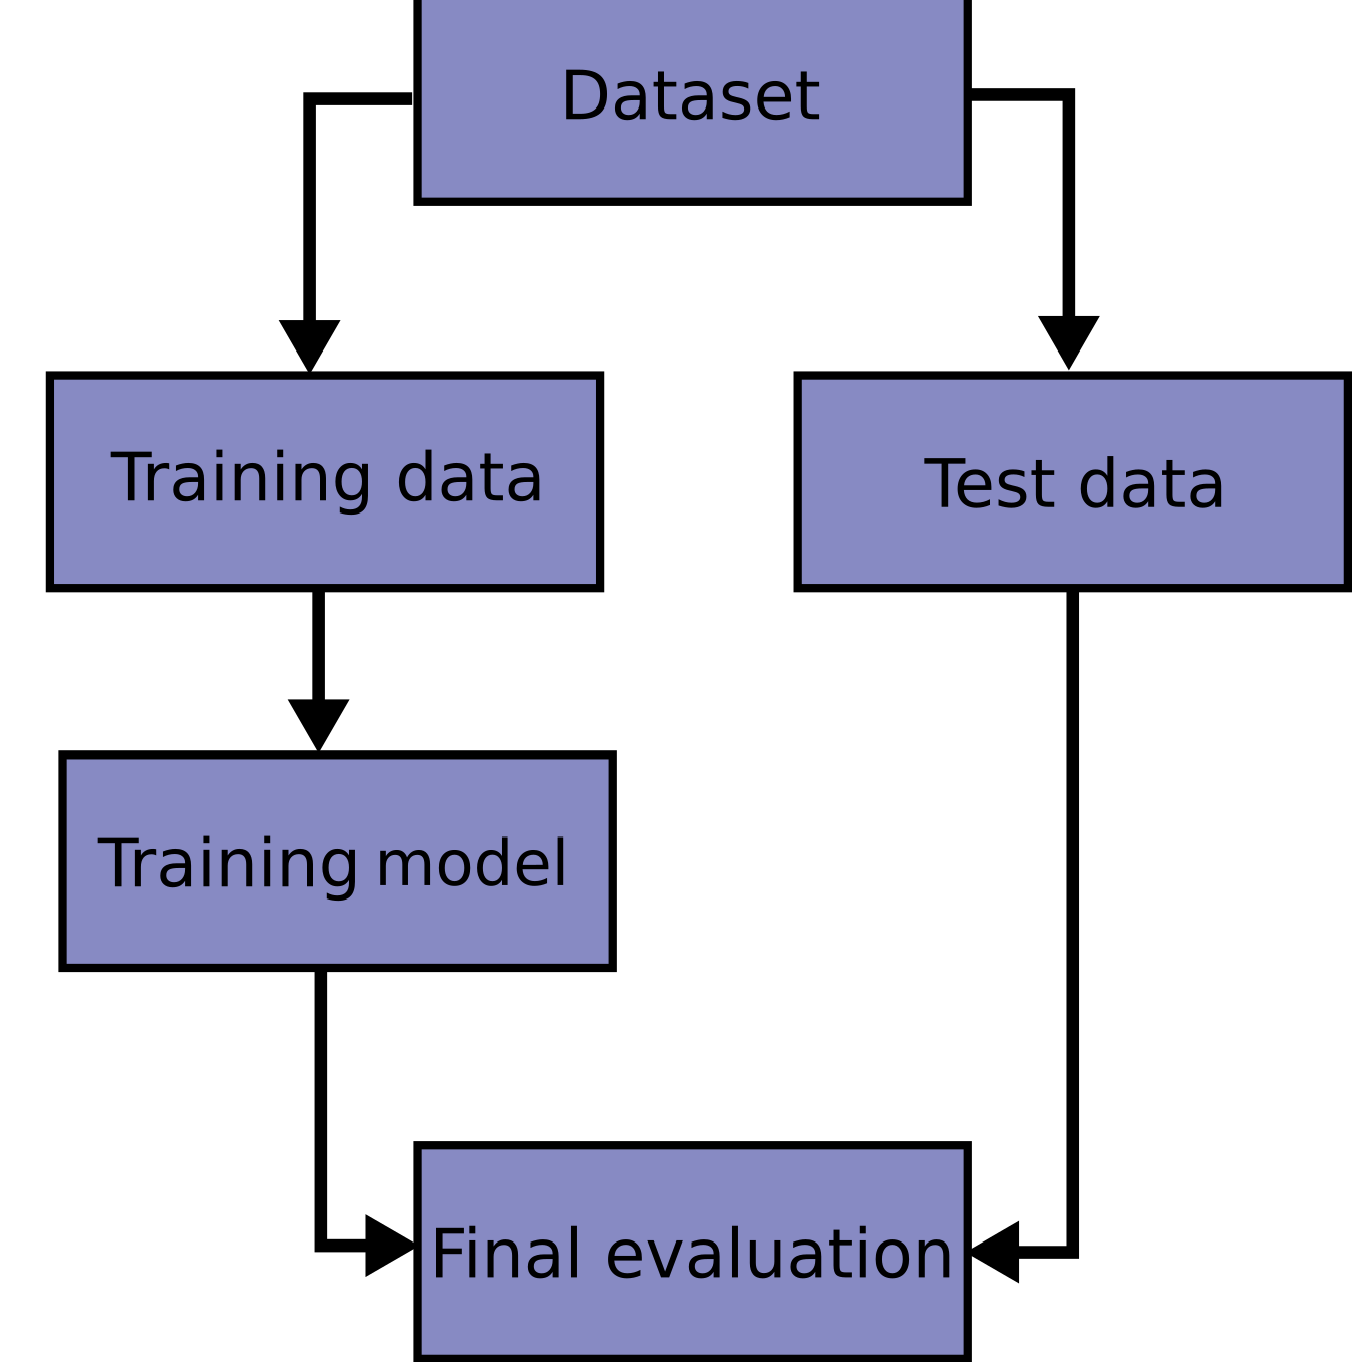

In [8]:
Image('img/grid_search_workflow_simple.png', width='50%')

1. Исходный набор данных делится на обучающую и тестовую выборку (например, с помощью функции train_test_split)
1. Обучающая выборка используется для обучения модели.
1. Тестовая выборка используется для оценки качества модели на основе выбранных метрик качества.

**К основным недостаткам** упрощенной модели можно отнести:
- Ручная установка гиперпараметров. Гиперпараметры модели устанавливаются случайным образом и непонятно как найти комбинацию гиперпараметров, которая будет лучшей для модели.
- Однократное разбиение на обучающую и тестовую выборку приводит к вычислению "неточной" (смещенной) оценки метрики качества.

Для того, чтобы подобрать гиперпараметры, необходимо перебрать все возможные варианты гиперпараметров и данных для всего исходного датасета (не только для обучающей выборки).

Таким образом, необходимо решить две задачи:

1) [Оптимизация гиперпараметров.](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2) Наиболее простой метод - Grid Search (поиск по решетке, решетчатый поиск).

2) Оптимизацию гиперпараметров необходимо выполнять на полном датасете. Таким образом, исходный датасет необходимо разбить на обучающие и тестовые выборки в различных комбинациях, чтобы получить несмещенную оценку вычисляемой метрики. Этот процесс называют [кросс-валидация](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0) (скользящий контроль, перекрестная проверка), англ. [cross-validation.](https://en.wikipedia.org/wiki/Cross-validation_(statistics))


Для того, чтобы избежать недообучения и переобучения используется следующая схема обучения (иллюстрация из описания библиотеки scikit-learn):

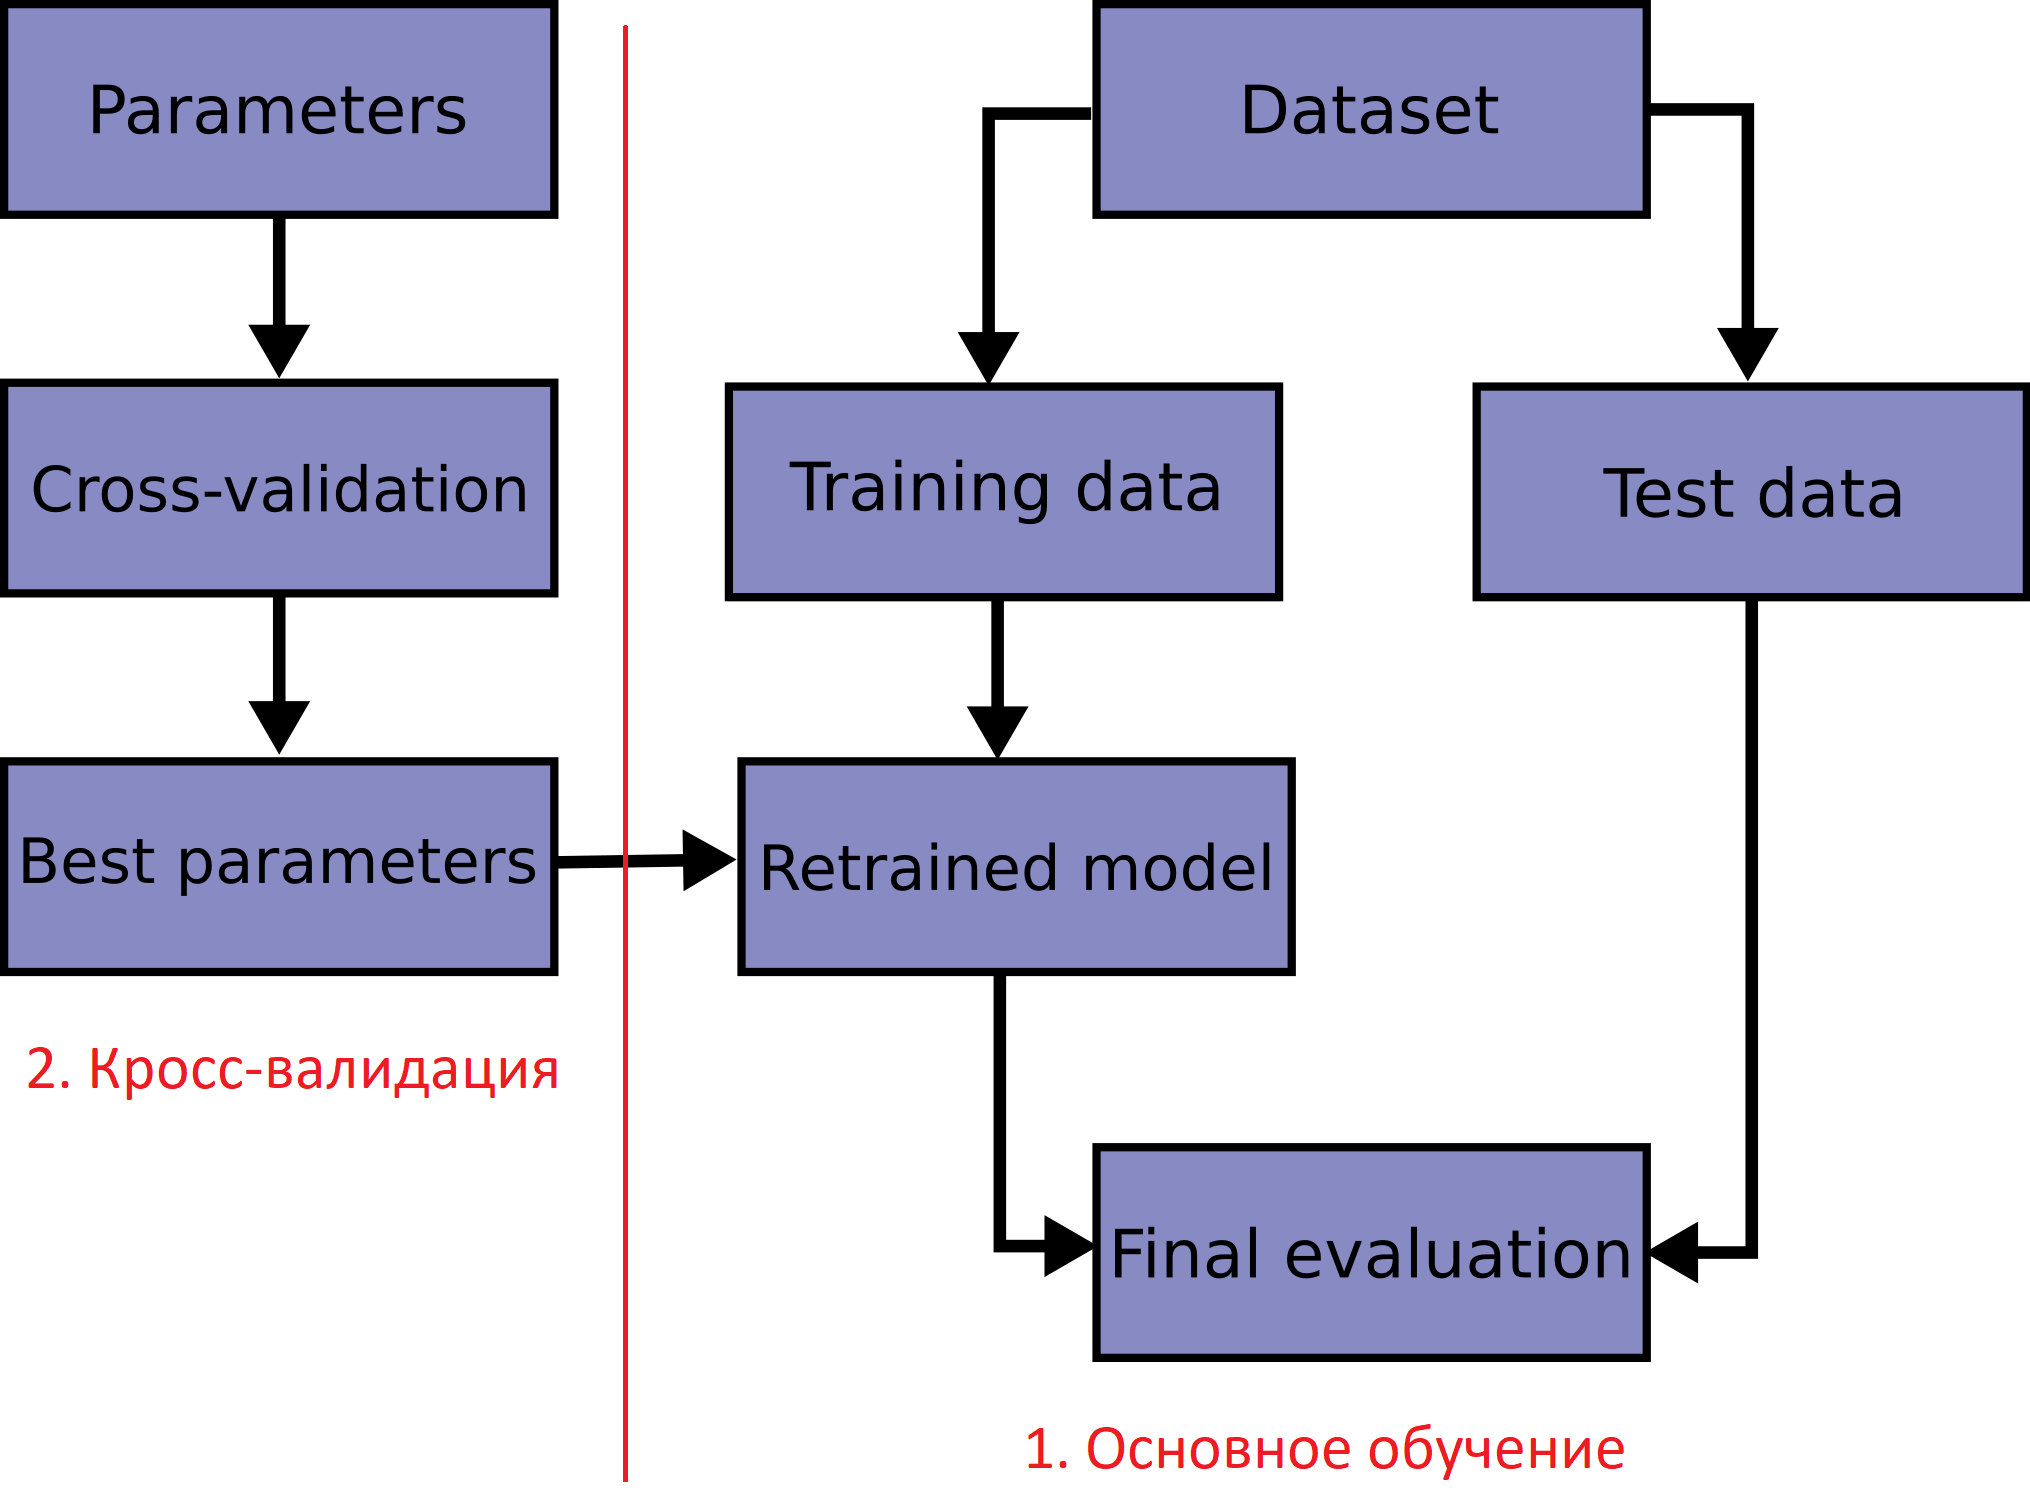

In [9]:
Image('img/grid_search_workflow_2.png', width='80%')

# [Кросс-валидация](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0) (скользящий контроль, перекрестная проверка), [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
- [Раздел по кросс-валидации в scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)

В Википедии смысл перекрестной проверки объясняется следующим образом:

Перекрестная проверка — метод оценки аналитической модели и её поведения на независимых данных. При оценке модели имеющиеся в наличии данные разбиваются на k частей. Затем на k−1 частях данных производится обучение модели, а оставшаяся часть данных используется для тестирования. Процедура повторяется k раз; в итоге каждая из k частей данных используется для тестирования. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных. 

К данному определению необходимо сделать следующие примечания:
- Каждую из k частей принято называть fold (фолд). 
- Количество фолдов при кросс-валидации обычно обозначают параметром cv.
- В результате каждого обучения и проверки модели формируются указанные разработчиком метрики качества модели. 

Например, в результате кросс-валидации для 3 фолдов при решении задачи классификации мы можем получить 3 значения accuracy, которые были вычислены для каждой комбинации фолдов. Полученные метрики обычно усредняют.

<table style="text-align:left">
    <tr><td>Fold 1</td><td>Fold 2</td><td>Fold 3</td><td>Accuracy</td></tr>
    <tr><td style="background-color:red">Fold 1</td><td>Fold 2</td><td>Fold 3</td><td>acc1</td></tr>
    <tr><td>Fold 1</td><td style="background-color:red">Fold 2</td><td>Fold 3</td><td>acc2</td></tr>    
    <tr><td>Fold 1</td><td>Fold 2</td><td style="background-color:red">Fold 3</td><td>acc3</td></tr>
    <tr><td colspan="4">Accuracy = np.mean([acc1, acc2, acc3])</td></tr>
<table>


- Существуют различные способы (стратегии) разбиения выборки на k частей, которые называют стратегиями кросс-валидации (cross-validation splitting strategy).


Наиболее простым способом кросс-валидации является вызов функции [cross_val_score.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) В этом случае стратегия кросс-валидации определяется автоматически.

In [10]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         iris.data, iris.target, cv=3)

In [11]:
# Значение метрики accuracy для 3 фолдов
scores

array([0.96, 0.94, 0.94])

In [12]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.9466666666666667

In [13]:
# использование метрики f1
# https://scikit-learn.org/stable/modules/model_evaluation.html
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         iris.data, iris.target, cv=3,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.95977778, 0.9398894 , 0.93994805]), 0.9465384102158296)

В отличие от функции cross_val_score, функция [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) позволяет использовать для оценки несколько метрик и возращает более детальную информацию. 

In [14]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [15]:
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        iris.data, iris.target, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.00099635, 0.00099778, 0.        ]),
 'score_time': array([0.00797868, 0.00897503, 0.00598431]),
 'test_precision': array([0.96421053, 0.94088889, 0.94097222]),
 'train_precision': array([0.9725    , 0.98111111, 0.98114286]),
 'test_recall': array([0.96, 0.94, 0.94]),
 'train_recall': array([0.97, 0.98, 0.98]),
 'test_f1': array([0.95977778, 0.9398894 , 0.93994805]),
 'train_f1': array([0.96995987, 0.97997321, 0.97998162])}

## Стратегии кросс-валидации

Все стратегии кросс-валидации основаны на том, что разработчик задает или количество разбиений (в этом случае автоматически определяются размеры обучающей и тестовой выборок для каждого разбиения) или размер обучающей или тестовой выборки для одного разбиения (в этом случае автоматически определяется количество разбиений). 

### [K-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

Данная стратегия работает в соответствии с определением кросс-валидации.

Каждой стратегии в scikit-learn ставится в соответствии специальный класс-итератор, который может быть указан в качестве параметра cv функций cross_val_score и cross_validate.

In [16]:
# Возвращаются индексы элементов
X = ["a", "b", "c"]
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[1 2] [0]
[0 2] [1]
[0 1] [2]


In [17]:
X = range(12)
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


Все элементы данных по очереди фигурируют и в обучающей и в тестовой выборках.

Далее итератор может быть использован в функциях cross_val_score и cross_validate:

In [18]:
kf = KFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         iris.data, iris.target, scoring='f1_weighted', 
                         cv=kf)
scores

array([1.        , 1.        , 0.94736842, 0.90246769, 0.84615385])

In [19]:
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        iris.data, iris.target, scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.0009973 , 0.0009954 , 0.00199413, 0.        , 0.        ]),
 'score_time': array([0.00498772, 0.01196718, 0.01196885, 0.00598454, 0.00498819]),
 'test_precision': array([1.        , 1.        , 1.        , 0.92307692, 1.        ]),
 'train_precision': array([0.97641509, 0.97674419, 0.99206349, 0.98412698, 0.98397436]),
 'test_recall': array([1.        , 1.        , 0.9       , 0.9       , 0.73333333]),
 'train_recall': array([0.975     , 0.975     , 0.99166667, 0.98333333, 0.98333333]),
 'test_f1': array([1.        , 1.        , 0.94736842, 0.90246769, 0.84615385]),
 'train_f1': array([0.97497748, 0.97506521, 0.99172621, 0.98324923, 0.98305814])}

### [Repeated K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold)

Повторяет стратегию K-Fold заданное количество раз.

In [20]:
X = range(12)
kf = RepeatedKFold(n_splits=3, n_repeats=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 0  1  2  6  7  8  9 11] [ 3  4  5 10]
[ 0  1  3  4  5  6  9 10] [ 2  7  8 11]
[ 2  3  4  5  7  8 10 11] [0 1 6 9]
[ 0  2  3  4  7  8 10 11] [1 5 6 9]
[1 2 3 5 6 7 8 9] [ 0  4 10 11]
[ 0  1  4  5  6  9 10 11] [2 3 7 8]


### [Leave One Out (LOO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut)

В тестовую выборку помещается единственный элемент (One Out). Количество фолдов в этом случае определяется автоматически и равняется количеству элементов.

Данный метод более ресурсоемкий чем KFold.

Существует эмпирическое правило, что вместо Leave One Out лучше использовать KFold на 5 или 10 фолдов.

In [21]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = LeaveOneOut()
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 1  2  3  4  5  6  7  8  9 10 11] [0]
[ 0  2  3  4  5  6  7  8  9 10 11] [1]
[ 0  1  3  4  5  6  7  8  9 10 11] [2]
[ 0  1  2  4  5  6  7  8  9 10 11] [3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


### [Leave P Out (LPO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html#sklearn.model_selection.LeavePOut)

В тестовую выборку помещается P элементов (P Out), полностью перебираются все уникальные комбинации из P элементов. Количество фолдов в этом случае определяется автоматически. 

In [22]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = LeavePOut(2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 2  3  4  5  6  7  8  9 10 11] [0 1]
[ 1  3  4  5  6  7  8  9 10 11] [0 2]
[ 1  2  4  5  6  7  8  9 10 11] [0 3]
[ 1  2  3  5  6  7  8  9 10 11] [0 4]
[ 1  2  3  4  6  7  8  9 10 11] [0 5]
[ 1  2  3  4  5  7  8  9 10 11] [0 6]
[ 1  2  3  4  5  6  8  9 10 11] [0 7]
[ 1  2  3  4  5  6  7  9 10 11] [0 8]
[ 1  2  3  4  5  6  7  8 10 11] [0 9]
[ 1  2  3  4  5  6  7  8  9 11] [ 0 10]
[ 1  2  3  4  5  6  7  8  9 10] [ 0 11]
[ 0  3  4  5  6  7  8  9 10 11] [1 2]
[ 0  2  4  5  6  7  8  9 10 11] [1 3]
[ 0  2  3  5  6  7  8  9 10 11] [1 4]
[ 0  2  3  4  6  7  8  9 10 11] [1 5]
[ 0  2  3  4  5  7  8  9 10 11] [1 6]
[ 0  2  3  4  5  6  8  9 10 11] [1 7]
[ 0  2  3  4  5  6  7  9 10 11] [1 8]
[ 0  2  3  4  5  6  7  8 10 11] [1 9]
[ 0  2  3  4  5  6  7  8  9 11] [ 1 10]
[ 0  2  3  4  5  6  7  8  9 10] [ 1 11]
[ 0  1  4  5  6  7  8  9 10 11] [2 3]
[ 0  1  3  5  6  7  8  9 10 11] [2 4]
[ 0  1  3  4  6  7  8  9 10 11] [2 5]
[ 0  1  3  4  5  7  8  9 10 11] [2 6]
[ 0  1  3  4  5  6  8  9 10 11] [2 7]
[ 0 

### [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit)

Генерируется N случайных перемешиваний данных, в каждом перемешивании заданная доля помещается в тестовую выборку.

In [23]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = ShuffleSplit(n_splits=5, test_size=0.25)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 6  4  9  5  7  8 11  3  2] [10  0  1]
[10  8  0  2 11  5  4  7  6] [3 9 1]
[ 7  8  5 11  6 10  0  3  2] [9 1 4]
[ 3 10  5  9  1  0  7  8 11] [2 6 4]
[11  5  6  9  4  3  7  1 10] [8 0 2]


### Модели со стратификацией используются для дисбалансированных выборок

- [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)
- [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit)

In [24]:
X = np.ones(10)
y = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[1 2 6 7 8 9] [0 3 4 5]
[0 2 3 4 5 8 9] [1 6 7]
[0 1 3 4 5 6 7] [2 8 9]


In [25]:
X = np.ones(10)
y = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[1 2 4 5 6 7 8 9] [0 3]
[0 2 3 5 6 7 8 9] [1 4]
[0 1 3 4 6 7 8 9] [2 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [26]:
X = np.ones(10)
y = [0, 0, 0, 0, 1, 0, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[1 2 3 5 6 7 8 9] [0 4]
[0 2 3 4 5 7 8 9] [1 6]
[0 1 3 4 5 6 8 9] [2 7]
[0 1 2 4 5 6 7 9] [3 8]
[0 1 2 3 4 6 7 8] [5 9]


# [Оптимизация гиперпараметров](https://scikit-learn.org/stable/modules/grid_search.html)

### [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (решетчатый поиск)

In [27]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [28]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(iris_X_train, iris_y_train)

Wall time: 130 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='accuracy')

In [29]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00119696, 0.00099678, 0.00079784, 0.00079794, 0.00079789,
        0.00079803, 0.00099959, 0.00059814, 0.00039892, 0.00019937]),
 'std_fit_time': array([7.46646075e-04, 1.21943587e-06, 3.98922081e-04, 3.98969835e-04,
        3.98945819e-04, 3.99017419e-04, 4.95681343e-06, 4.88382996e-04,
        4.88577633e-04, 3.98731232e-04]),
 'mean_score_time': array([0.0015954 , 0.00199494, 0.00139647, 0.00119686, 0.00159559,
        0.00159597, 0.00119419, 0.00159559, 0.00119691, 0.00139618]),
 'std_score_time': array([0.00048825, 0.00063068, 0.00048799, 0.00039864, 0.0004886 ,
        0.00119686, 0.00040012, 0.00079684, 0.00039873, 0.00048871]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_ne

In [30]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier()

In [31]:
# Лучшее значение метрики
clf_gs.best_score_

0.9733333333333334

In [32]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 5}

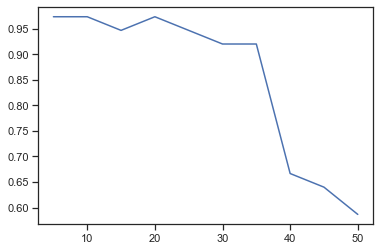

In [33]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

### [Randomized Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) (случайный поиск)

Используется в том случае когда полный решетчатый поиск работает слишком долго.

In [34]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(iris_X_train, iris_y_train)

Wall time: 141 ms


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
                   scoring='accuracy')

In [35]:
# В данном случае оба способа нашли одинаковое решение
clf_rs.best_score_, clf_rs.best_params_

(0.9733333333333334, {'n_neighbors': 5})

In [36]:
clf_gs.best_score_, clf_gs.best_params_

(0.9733333333333334, {'n_neighbors': 5})

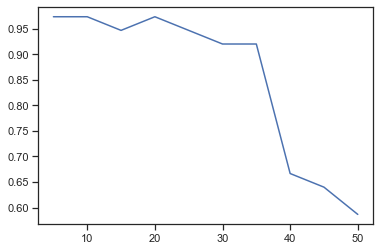

In [37]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_rs.cv_results_['mean_test_score'])

**Примечания.** 
- В том случае когда для гиперпараметров решается не задача перебора, а вложенная задача оптимизации используется метод вложенной кросс-валидации ([Nested cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py)).
- В разделе 3.2.3 [руководства](https://scikit-learn.org/stable/modules/grid_search.html) рассмотрены советы по подбору параметров.
- В разделе 3.2.4 [руководства](https://scikit-learn.org/stable/modules/grid_search.html) рассмотрены варианты подбора параметров для некоторых классов моделей машинного обучения.
- Часто RandomizedSearchCV применяют для поиска "опорного" решения, а затем в "окрестности" полученного решения используют GridSearchCV.

### Другие способы

Для оптимизации гиперпараметров также существуют отдельные от scikit-learn библиотеки и подходы:
- https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
- https://towardsdatascience.com/algorithms-for-hyperparameter-optimisation-in-python-edda4bdb167
- http://hyperopt.github.io/hyperopt/
- https://ray.readthedocs.io/en/latest/tune.html
- https://parameter-sherpa.readthedocs.io/en/latest/

# [Построение кривых обучения и валидации](https://scikit-learn.org/stable/modules/learning_curve.html)

## Построение кривых обучения - [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve)

Строится зависимость метрики на обучающей выборке от размера выборки.

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

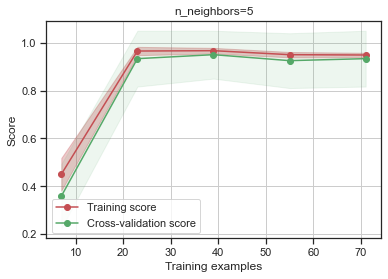

In [39]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=5), 'n_neighbors=5', 
                    iris_X_train, iris_y_train, cv=20)

## Построение кривой валидации - [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve)

Строится зависимость метрики на тестовой выборке от одного из гиперпараметров.

In [40]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

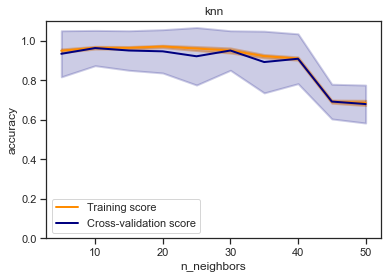

In [41]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      iris_X_train, iris_y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=20, scoring="accuracy")

# Комплексный пример c решетчатым поиском и кросс-валидацией

In [42]:
# 1.Формирование обучающей и тестовой выборки
iris = load_iris()
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris.data, iris.target, test_size=0.5, random_state=1)

In [43]:
# 2.Первичное обучение модели и оценка качества
cl1_1 = KNeighborsClassifier(n_neighbors=50)
cl1_1.fit(iris_X_train, iris_y_train)
target1_0 = cl1_1.predict(iris_X_train)
target1_1 = cl1_1.predict(iris_X_test)
accuracy_score(iris_y_train, target1_0), accuracy_score(iris_y_test, target1_1)

(0.68, 0.6266666666666667)

In [44]:
# 3.Оценка качества модели с использованием кросс-валидации
scores = cross_val_score(KNeighborsClassifier(n_neighbors=50), 
                         iris.data, iris.target, 
                         cv=LeaveOneOut())
scores, np.mean(scores)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 0.9266666666666666)

In [45]:
# 4.Подбор гиперпараметров на основе решетчатого поиска и кросс-валидации
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [46]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=LeaveOneOut(), scoring='accuracy')
clf_gs.fit(iris.data, iris.target)

Wall time: 2.51 s


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='accuracy')

In [47]:
clf_gs.best_params_

{'n_neighbors': 20}

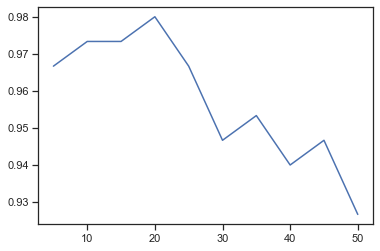

In [48]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [49]:
# 5.Обучение модели и оценка качества с учетом подобранных гиперпараметров
clf_gs.best_estimator_.fit(iris_X_train, iris_y_train)
target2_0 = clf_gs.best_estimator_.predict(iris_X_train)
target2_1 = clf_gs.best_estimator_.predict(iris_X_test)

In [50]:
# Новое качество модели
accuracy_score(iris_y_train, target2_0), accuracy_score(iris_y_test, target2_1)

(0.9733333333333334, 0.9466666666666667)

In [51]:
# Качество модели до подбора гиперпараметров
accuracy_score(iris_y_train, target1_0), accuracy_score(iris_y_test, target1_1)

(0.68, 0.6266666666666667)

In [52]:
# 6.Построение кривых обучения и валидации

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

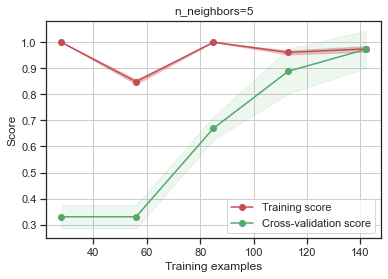

In [53]:
plot_learning_curve(clf_gs.best_estimator_, 'n_neighbors=5', 
                    iris.data, iris.target, cv=20, train_sizes=np.linspace(.2, 1.0, 5))

In [54]:
n_range2 = np.array(range(5,125,5))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

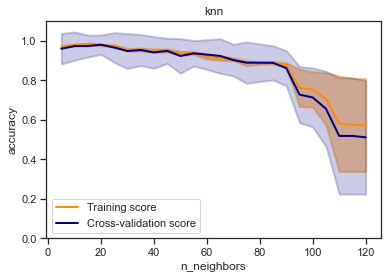

In [55]:
plot_validation_curve(clf_gs.best_estimator_, 'knn', 
                      iris.data, iris.target, 
                      param_name='n_neighbors', param_range=n_range2, 
                      cv=20, scoring="accuracy")

# Дополнительные источники:
1. http://www.machinelearning.ru/wiki/index.php?title=CV
1. http://datascientist.one/cross-validation/
1. http://datareview.info/article/sravnenie-razlichnyih-vidov-kross-validatsii/
1. https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229